# Q.5 Understanding the bias-variance trade-off

In [1]:
#All imports

import numpy as np
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import collections
import ipywidgets as widgets
from IPython.display import display
from ipywidgets import interact, IntSlider

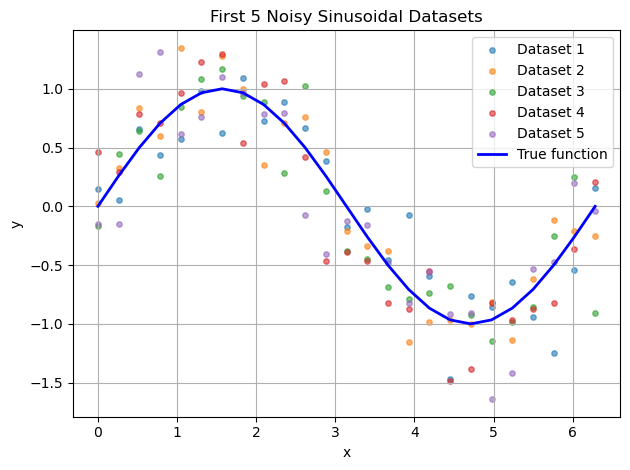

First dataset sample:
          x         y
0  0.000000  0.146179
1  0.261799  0.054107
2  0.523599  0.660548
3  0.785398  0.432761
4  1.047198  0.576623


In [2]:
########################################
#Generate 100 data sets of noisy sinusoidal data
########################################
L = 100
N = 25
noise_std = 0.3
x= np.linspace(0, 2*np.pi, N)
x_norm = x / (2 * np.pi)

# Generating datasets
all_datasets = []
for i in range(L):
    y_true = np.sin(x);
    y_noisy = y_true + np.random.normal(0, noise_std, size=N)
    dataset = np.column_stack((x, y_noisy))
    all_datasets.append((dataset))
    if i < 5:
        plt.scatter(x, y_noisy, s=15, alpha=0.6, label=f'Dataset {i+1}')

plt.plot(x, np.sin(x),  color='blue', linewidth=2.0, label='True function')
plt.title("First 5 Noisy Sinusoidal Datasets")
plt.xlabel("x")
plt.ylabel("y")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

df_list = [pd.DataFrame(data, columns=['x', 'y']) for data in all_datasets]
print("First dataset sample:")
print(df_list[0].head())

In [3]:
def gaussian_features_fixed(X, M=24, sigma=0.1):
    centers = np.linspace(0, 1, M)
    features = np.zeros((len(X), M))
    for j in range(M):
        mu_j = centers[j]
        features[:, j] = np.exp(-(X - mu_j)**2 / (2 * sigma**2))
    features = np.hstack([np.ones((len(X), 1)), features])
    return features

In [4]:
Phi_list = []
Y_list = []
for data in all_datasets:
    x_i = data[:, 0] / (2 * np.pi)
    y_i = data[:, 1]
    Phi_i = gaussian_features_fixed(x_i)
    Phi_list.append(Phi_i)
    Y_list.append(y_i)

In [5]:
########################################
#Use regularized least squares to estimate w
########################################

def ridge_regression(Phi, y, lam):
    """
    Solves (ΦᵀΦ + λI)w = Φᵀy for w
    """
    M = Phi.shape[1]
    I = np.eye(M)
    return np.linalg.solve(Phi.T @ Phi + lam * I, Phi.T @ y)

lambda_val = 1.0
W_list = [ridge_regression(Phi_list[i], Y_list[i], lambda_val) for i in range(L)]


In [6]:
x_plot = np.linspace(0, 1, 200)
Phi_plot = gaussian_features_fixed(x_plot)
def plot_dataset(i):
    Phi = Phi_list[i]
    y = Y_list[i]
    w = ridge_regression(Phi, y, lam=0.01)
    y_fit = Phi_plot @ w

    plt.figure(figsize=(7, 3.5))
    plt.scatter(Phi[:, 1], y, alpha=0.5, s=15, color='blue', label='Noisy Data')
    plt.plot(x_plot, y_fit, '-', color='grey', linewidth=2, label=f'Fitted Curve')
    plt.plot(x_plot, np.sin(x_plot * 2 * np.pi), '--', color='black', label='True Function')

    plt.title(f"Ridge Regression Fit | Dataset {i} | λ = 0.01")
    plt.xlabel("x (normalized)")
    plt.ylabel("y")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

interact(plot_dataset, i=(0, L-1));

interactive(children=(IntSlider(value=49, description='i', max=99), Output()), _dom_classes=('widget-interact'…

In [7]:
# Bias-Variance Curves
def compute_bias_variance(Phi_plot, lam):
    y_preds = np.array([
        Phi_plot @ ridge_regression(Phi_list[i], Y_list[i], lam)
        for i in range(L)
    ])
    y_mean = np.mean(y_preds, axis=0)
    y_true = np.sin(x_plot * 2 * np.pi)
    bias_sq = (y_mean - y_true)**2
    variance = np.var(y_preds, axis=0)
    return bias_sq, variance, y_preds

bias_sq, variance, y_preds = compute_bias_variance(Phi_plot, lam=0.01)

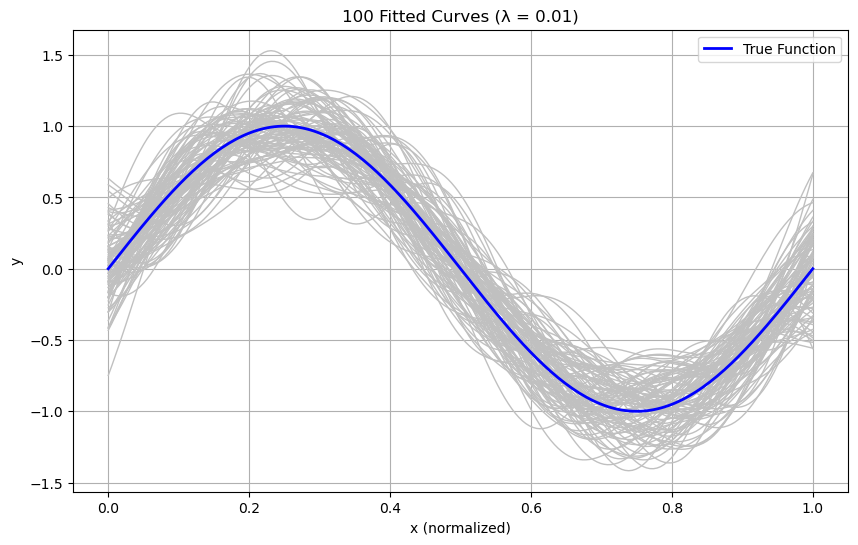

In [8]:
########################################
#Illustrate the concept of Bias-Variance trade off
########################################

plt.figure(figsize=(10, 6))
for i in range(100):
    Phi_i = Phi_list[i]
    y_i = Y_list[i]

    w_i = ridge_regression(Phi_i, y_i, lam=0.01)
    y_plot_i = Phi_plot @ w_i
    plt.plot(x_plot, y_plot_i, color='silver', linewidth=1)

plt.plot(x_plot, np.sin(x_plot * 2 * np.pi), '-', label='True Function', linewidth=2, color='blue')

plt.title("100 Fitted Curves (λ = 0.01)")
plt.xlabel("x (normalized)")
plt.ylabel("y")
plt.grid(True)
plt.legend()
plt.show()

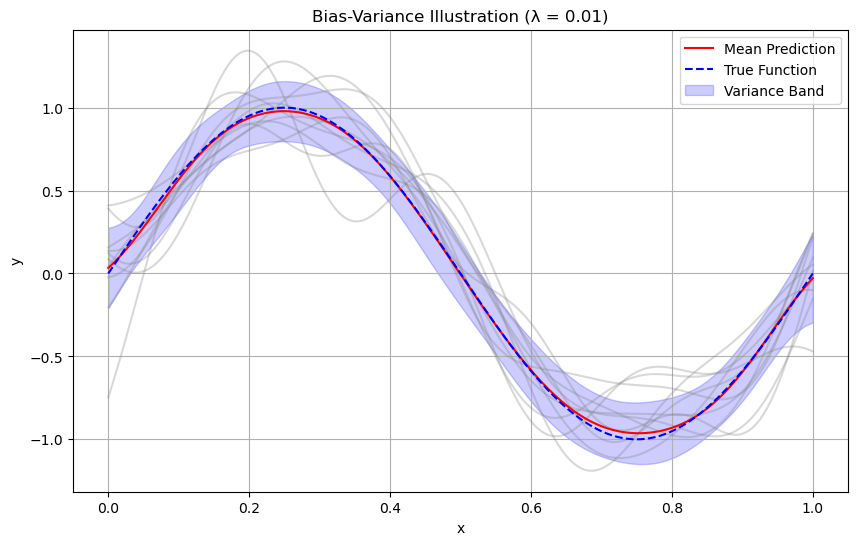

In [9]:
plt.figure(figsize=(10, 6))
for i in range(0, 100, 10):
    plt.plot(x_plot, y_preds[i], color='gray', alpha=0.3)

plt.plot(x_plot, np.mean(y_preds, axis=0), 'r-', label='Mean Prediction')

plt.plot(x_plot, np.sin(x_plot * 2 * np.pi), 'b--', label='True Function')

plt.fill_between(x_plot, np.mean(y_preds, axis=0) - np.sqrt(variance), np.mean(y_preds, axis=0) + np.sqrt(variance),
                 color='blue', alpha=0.2, label='Variance Band')

plt.title("Bias-Variance Illustration (λ = 0.01)")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.grid(True)
plt.show()


The plot above shows 100 fitted curves from ridge regression models trained on different noisy datasets, all using the same λ = 0.01.  
Variance: The spread of the 100 gray curves indicates model variance.The width of the blue shaded area shows how much predictions vary across datasets. Since the curves are relatively close to each other, the variance is moderate.  
Bias: The average prediction(red curve) are close to the true function (blue curve), suggesting low bias.  
This plot demonstrates how models can differ across datasets due to noise, even when trained with the same hyperparameters.


Average total error MSE: 0.1211


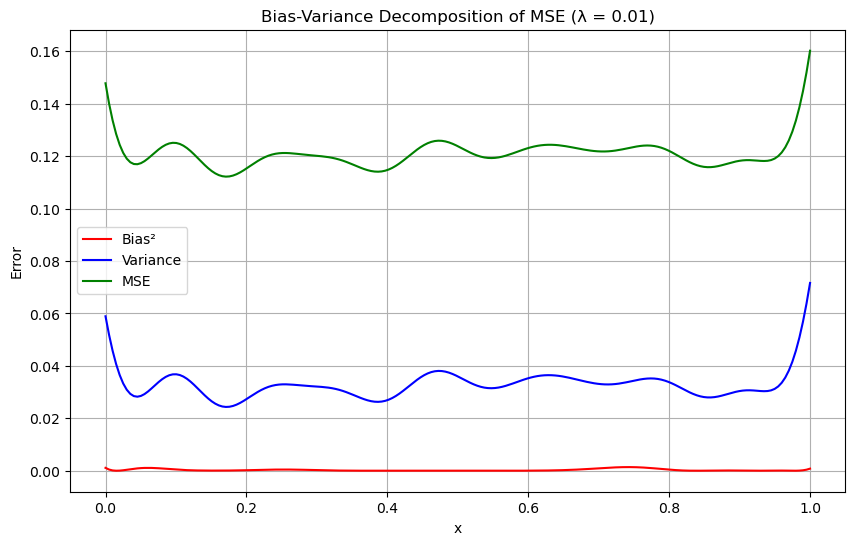

In [11]:
#Decomposition: Bias² + Var + Noise

estimated_noise_var = np.mean([np.var(Y_list[i] - np.sin(all_datasets[i][:, 0])) for i in range(L)])

mse = bias_sq + variance + estimated_noise_var
total_error = np.mean(mse)
print(f"Average total error MSE: {total_error:.4f}")

# Plot Bias², Variance, and MSE
plt.figure(figsize=(10, 6))
plt.plot(x_plot, bias_sq, label='Bias²', color='red')
plt.plot(x_plot, variance, label='Variance', color='blue')
plt.plot(x_plot, mse, label='MSE', color='green')
plt.title("Bias-Variance Decomposition of MSE (λ = 0.01)")
plt.xlabel("x")
plt.ylabel("Error")
plt.legend()
plt.grid(True)
plt.show()



High bias²: Mean prediction is far from true function (underfitting).  
High variance: Predictions vary greatly across datasets (overfitting).  
MSE peaks: Indicate areas where the model performs poorly.

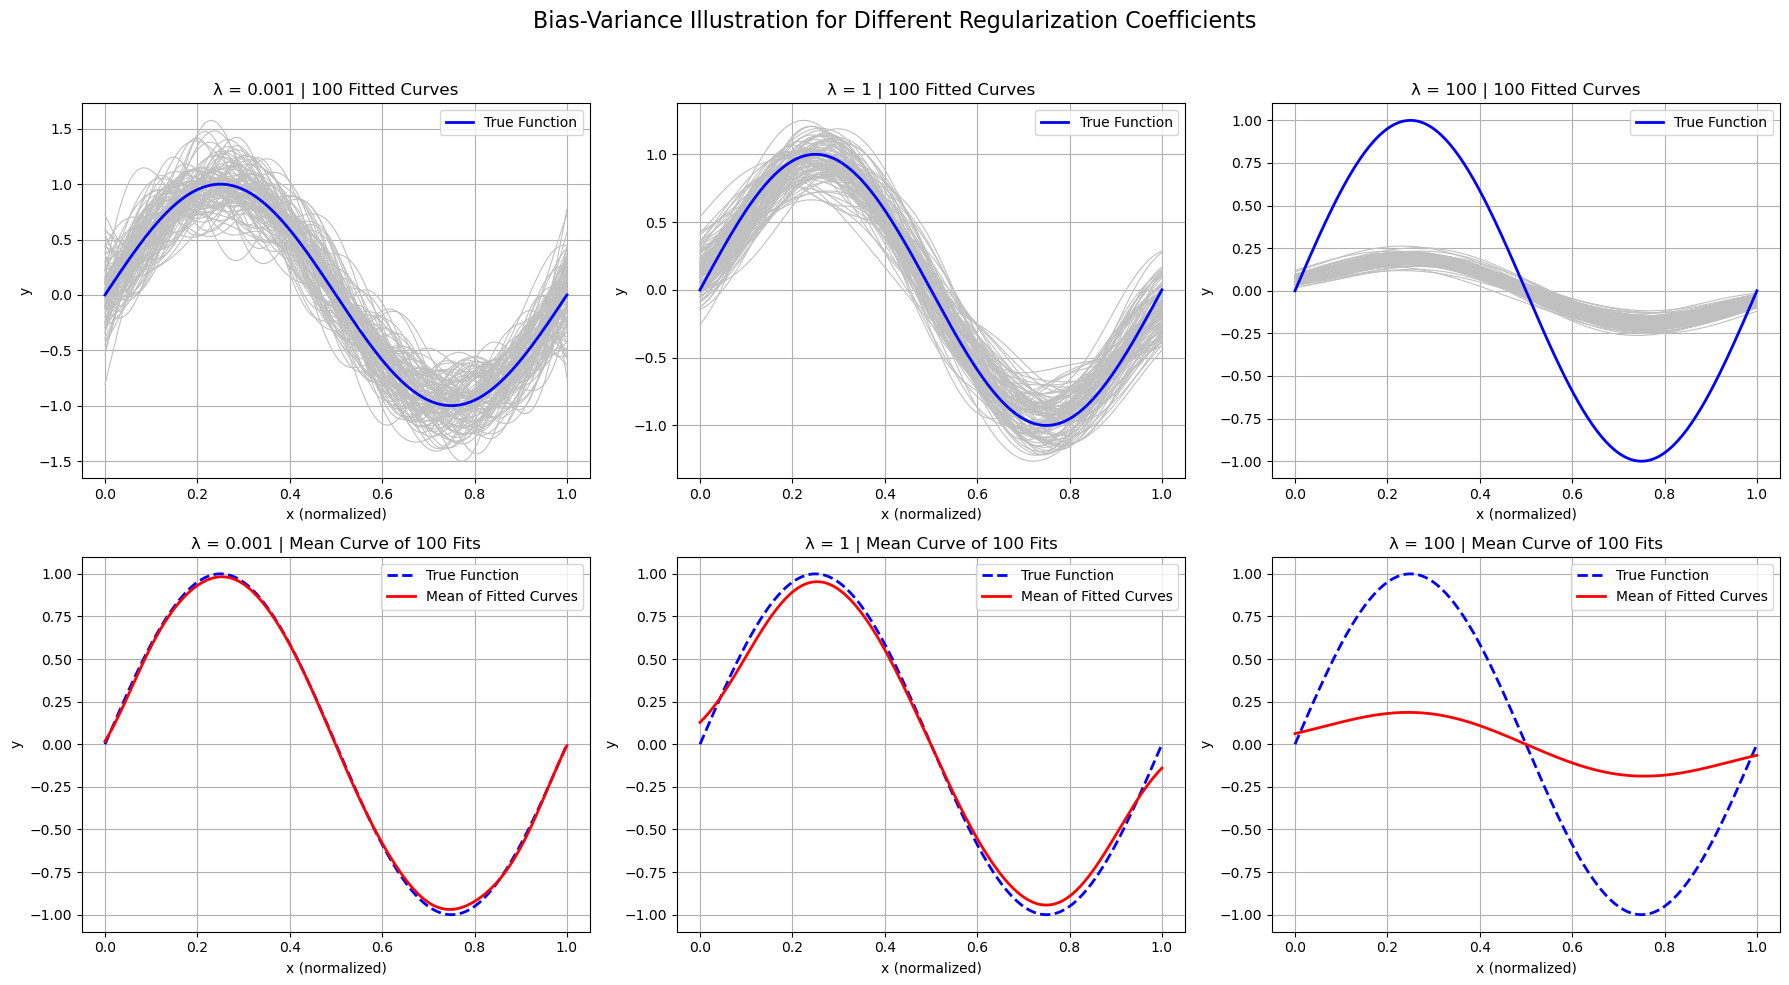

In [12]:
#1. Chose three different regularization coefficeints (low,middle and high)

lambda_values = [1e-3, 1, 100]  # Low, Medium, High
true_function = np.sin(2 * np.pi * x_plot)

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle("Bias-Variance Illustration for Different Regularization Coefficients", fontsize=16)

for col, lam in enumerate(lambda_values):

    Y_fitted_all = []

    # Plot 100 individual fits
    ax = axes[0, col]
    for i in range(100):
        Phi_i = Phi_list[i]
        y_i = Y_list[i]
        w_i = ridge_regression(Phi_i, y_i, lam=lam)
        y_fit_i = Phi_plot @ w_i
        Y_fitted_all.append(y_fit_i)
        ax.plot(x_plot, y_fit_i, color='silver', linewidth=0.8)

    # Plot true function
    ax.plot(x_plot, true_function, 'b-', label='True Function', linewidth=2)
    ax.set_title(f"λ = {lam} | 100 Fitted Curves")
    ax.set_xlabel("x (normalized)")
    ax.set_ylabel("y")
    ax.grid(True)
    ax.legend()

    # Plot Mean Curve
    ax = axes[1, col]
    Y_fitted_all = np.array(Y_fitted_all)
    y_mean = Y_fitted_all.mean(axis=0)

    ax.plot(x_plot, true_function, 'b--', label='True Function', linewidth=2)
    ax.plot(x_plot, y_mean, 'r-', label='Mean of Fitted Curves', linewidth=2)
    ax.set_title(f"λ = {lam} | Mean Curve of 100 Fits")
    ax.set_xlabel("x (normalized)")
    ax.set_ylabel("y")
    ax.grid(True)
    ax.legend()
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()



Bias Variance Tradeoff

- The top row shows fitted curves across datasets. It shows variance - the spread of fitted curves indicates how sensitive the model is to dataset variations.

- The bottom row (mean vs trur function) shows bias - the deviation of the average prediction from the true function.

- Effect of Regularization λ:
  - Low λ leads to low bias but high variance.(Overfitting)
  - High λ leads to low variance but high bias. Model is too rigid and underfits the data.

- Mean Squared Error (MSE) Decomposition:
  - MSE = Bias² + Variance + Noise
  - Plotting these components shows that MSE is minimized at an intermediate value of λ, balancing both bias and variance.


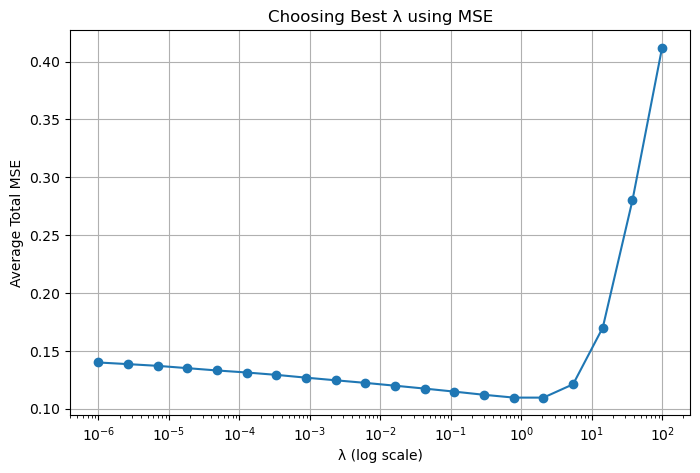

Best λ that minimizes MSE: 2.0691


In [13]:
lambda_range = np.logspace(-6, 2, 20)  # Try 20 λ values from 1e-6 to 1e2
mse_list = []

for lam in lambda_range:
    bias_sq, variance, _ = compute_bias_variance(Phi_plot, lam)
    mse = bias_sq + variance + estimated_noise_var
    mse_list.append(np.mean(mse))

# Plot MSE vs Lambda
plt.figure(figsize=(8, 5))
plt.plot(lambda_range, mse_list, marker='o')
plt.xscale('log')
plt.xlabel("λ (log scale)")
plt.ylabel("Average Total MSE")
plt.title("Choosing Best λ using MSE")
plt.grid(True)
plt.show()

# Find λ that gives minimum MSE
best_lambda = lambda_range[np.argmin(mse_list)]
print(f"Best λ that minimizes MSE: {best_lambda:.4f}")


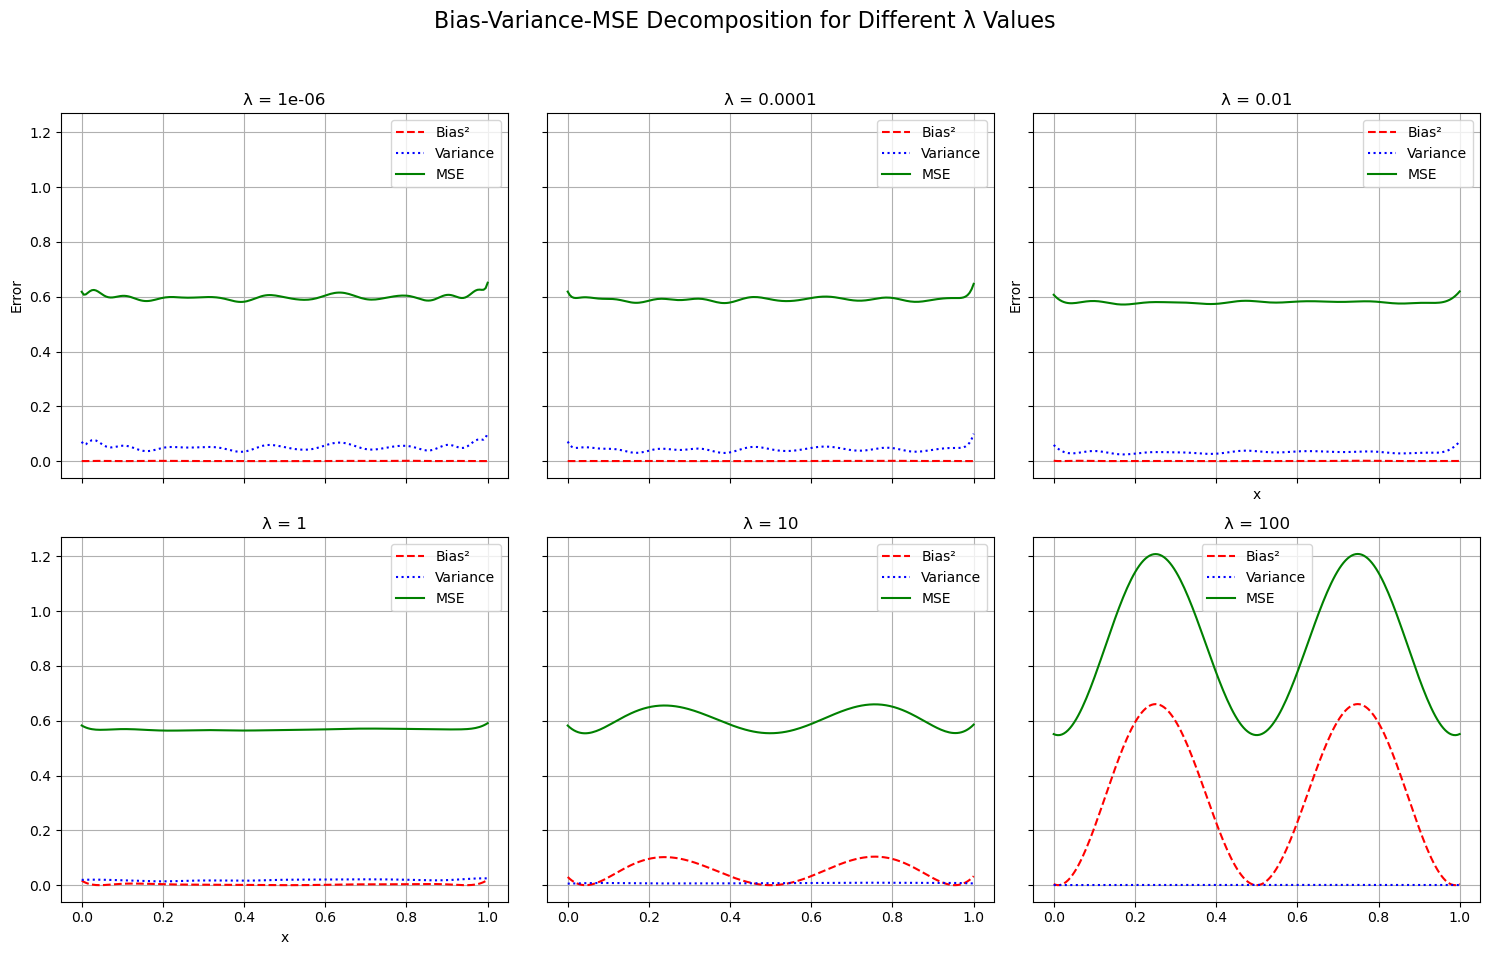

In [14]:
#same graph as above , just divided into 4
lambda_values = [1e-6, 1e-4, 1e-2, 1, 10, 100]
titles = [f"λ = {lam}" for lam in lambda_values]
colors = {'Bias²': 'red', 'Variance': 'blue', 'MSE': 'green'}

fig, axes = plt.subplots(2, 3, figsize=(15, 10), sharex=True, sharey=True)

# Estimate constant noise variance across datasets
estimated_noise_var = np.mean([
    np.var(Y_list[i] - np.sin(Phi_list[i][:, 1] * 2 * np.pi))
    for i in range(100)
])

for idx, (lam, ax) in enumerate(zip(lambda_values, axes.flat)):
    bias_sq, variance, y_preds = compute_bias_variance(Phi_plot, lam)
    mse = bias_sq + variance + estimated_noise_var

    ax.plot(x_plot, bias_sq, label='Bias²', color=colors['Bias²'], linestyle='--')
    ax.plot(x_plot, variance, label='Variance', color=colors['Variance'], linestyle=':')
    ax.plot(x_plot, mse, label='MSE', color=colors['MSE'], linestyle='-')

    ax.set_title(titles[idx])
    ax.grid(True)
    ax.legend()
    if idx in [2, 3]:
        ax.set_xlabel("x")
    if idx in [0, 2]:
        ax.set_ylabel("Error")

fig.suptitle("Bias-Variance-MSE Decomposition for Different λ Values", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


In [ ]:
def plot_bias_variance(lambda_exp):
    lam = 10 ** lambda_exp
    bias_sq, variance, _ = compute_bias_variance(Phi_plot, lam)
    mse = bias_sq + variance + estimated_noise_var

    # Plot
    plt.figure(figsize=(10, 6))
    plt.plot(x_plot, bias_sq, label='Bias²', color='red')
    plt.plot(x_plot, variance, label='Variance', color='blue')
    plt.plot(x_plot, mse, label='MSE (Bias² + Var + Noise)', color='green')
    plt.title(f"Bias-Variance Decomposition (λ = 10^{lambda_exp})")
    plt.xlabel("x")
    plt.ylabel("Error")
    plt.grid(True)
    plt.legend()
    plt.show()

interact(plot_bias_variance, lambda_exp=(-4.0, 2.0, 0.5));


Observations on Bias-Variance Tradeoff   

In this experiment, we explored the effect of the regularization parameter (λ) in ridge regression on model performance. Using 100 datasets with noisy observations and a fixed feature mapping (Gaussian basis), we estimated bias², variance, and MSE for different values of λ.   

**Observations**    

1. For Low Regularization (λ ≈ 1e-6 - 0.01):  
The model closely fits each dataset, resulting in low bias but higher variance.  
Predictions vary significantly between datasets, which leads to overfitting.  

2. Moderate Regularization (λ ≈ 1.0):  
A balance is achieved between bias and variance.  
MSE is minimized around this point.  

3. High Regularization (λ ≈ 10.0 or more):  
The model becomes overly smooth, failing to capture the true function well.  
This increases bias, while variance decreases drastically and leads to leads to underfitting.

Why Gaussian Basis Functions Were Used  
1. Localized: Only affect nearby input regions.  
2. Smooth & nonlinear: Capture patterns like sinusoids effectively.  
3. They avoid issues like wild oscillations common in high-degree polynomials.   
4. Improve interpretability and local fitting flexibility.

Hence they are well-suited for studying bias-variance behavior in controlled regions.
